In [1]:
from datasets import load_dataset

dataset = load_dataset('banking77')
dataset

Using custom data configuration default


Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Dataset banking77 downloaded and prepared to /home/vscode/.cache/huggingface/datasets/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})

In [2]:
dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=77, names=['activate_my_card', 'age_limit', 'apple_pay_or_google_pay', 'atm_support', 'automatic_top_up', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_about_to_expire', 'card_acceptance', 'card_arrival', 'card_delivery_estimate', 'card_linking', 'card_not_working', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'card_swallowed', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'change_pin', 'compromised_card', 'contactless_not_working', 'country_support', 'declined_card_payment', 'declined_cash_withdrawal', 'declined_transfer', 'direct_debit_payment_not_recognised', 'disposable_card_limits', 'edit_personal_details', 'exchange_charge', 'exchange_rate', 'exchange_via_app', 'extra_charge_on_statement', 'failed_transfer', 'fiat_currency_support', 'get_disposa

In [4]:
for t in dataset['train']['text'][550:555]:
    print(t)

Why was I charged a higher exchange rate when I bought something abroad?
Why didn't I receive the correct exchange rate for an item that I purchased?
Why is the exchange rate on my card payment different than I expected?
My rate of exchange was wrong.
I recently bought something in foreign currency and I am unsure of the exchange rate. Is this rate applied correctly?


In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

train_texts = [item["text"] for item in dataset["train"]]
train_labels = [item["label"] for item in dataset["train"]]

test_texts = [item["text"] for item in dataset["test"]]
test_labels = [item["label"] for item in dataset["test"]]

label_counter = Counter(train_labels)
label_names = dataset["train"].features["label"].names
label_frequencies = {label_names[label]: [label_counter[label]] for label in label_counter}


In [6]:
from sklearn.model_selection import train_test_split

train_texts, dev_texts, train_labels, dev_labels = train_test_split(train_texts, 
                                                                    train_labels, 
                                                                    test_size=0.1, 
                                                                    shuffle=True, 
                                                                    random_state=1)

print("Train:", len(train_texts))
print("Dev:", len(dev_texts))
print("Test:", len(test_texts))

Train: 9002
Dev: 1001
Test: 3080


In [9]:
import torch

class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [10]:
from sklearn.metrics import accuracy_score


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    acc = accuracy_score(labels, preds)

    return {'accuracy': acc}

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

model_ids = ["prajjwal1/bert-tiny", "prajjwal1/bert-mini", 
             "prajjwal1/bert-small", "prajjwal1/bert-medium",]

accuracies = []

for model_id in model_ids:
    print(f"  *** {model_id} ***")

    tokeninzer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=len(label_names))

    train_text_encoded = tokeninzer(train_texts, padding=True, truncation=True, return_tensors='pt')
    val_text_encoded = tokeninzer(dev_texts, padding=True, truncation=True, return_tensors='pt')
    test_text_encoded = tokeninzer(test_texts, padding=True, truncation=True, return_tensors='pt')

    train_dataset = ClassificationDataset(train_text_encoded, train_labels)
    val_dataset = ClassificationDataset(val_text_encoded, dev_labels)
    test_dataset = ClassificationDataset(test_text_encoded, test_labels)

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=int(len(train_dataset)/4),
        weight_decay=0.01,
        logging_dir='./logs',
        evaluation_strategy="steps",
        eval_steps=500,
        save_steps=500,
        save_total_limit=10,
        load_best_model_at_end=True,
        no_cuda=False
    )

    trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics, train_dataset=train_dataset, eval_dataset=val_dataset)

    trainer.train()
    test_results = trainer.evaluate(test_dataset)

    accuracies.append(test_results['eval_accuracy'])

  *** prajjwal1/bert-tiny ***


Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Step,Training Loss,Validation Loss,Accuracy
500,4.356000,4.338256,0.022977
1000,4.301300,4.223689,0.072927
1500,4.134000,3.934121,0.292707


***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
/tmp/ipykernel_3315/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
/tmp/ipykernel_3315/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True),

  *** prajjwal1/bert-mini ***


Could not locate the tokenizer configuration file, will try to use the model config instead.
https://huggingface.co/prajjwal1/bert-mini/resolve/main/config.json not found in cache or force_download set to True, downloading to /home/vscode/.cache/huggingface/transformers/tmpgpx6xcwz


Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

storing https://huggingface.co/prajjwal1/bert-mini/resolve/main/config.json in cache at /home/vscode/.cache/huggingface/transformers/a32529b12a03c02e99c269bf68c0c7b8349093f626e860ab9b012e3d9539c539.e6c2a1d71adb3143ecd42222c4604e92ff255a7663c04bb5c4fad770c78e096c
creating metadata file for /home/vscode/.cache/huggingface/transformers/a32529b12a03c02e99c269bf68c0c7b8349093f626e860ab9b012e3d9539c539.e6c2a1d71adb3143ecd42222c4604e92ff255a7663c04bb5c4fad770c78e096c
loading configuration file https://huggingface.co/prajjwal1/bert-mini/resolve/main/config.json from cache at /home/vscode/.cache/huggingface/transformers/a32529b12a03c02e99c269bf68c0c7b8349093f626e860ab9b012e3d9539c539.e6c2a1d71adb3143ecd42222c4604e92ff255a7663c04bb5c4fad770c78e096c
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-mini",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "interm

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/prajjwal1/bert-mini/resolve/main/vocab.txt in cache at /home/vscode/.cache/huggingface/transformers/62f8357e13eddc9798915fddaeb0de8bb9a14deda654be17fbfd049a56dd3b5a.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /home/vscode/.cache/huggingface/transformers/62f8357e13eddc9798915fddaeb0de8bb9a14deda654be17fbfd049a56dd3b5a.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-mini/resolve/main/vocab.txt from cache at /home/vscode/.cache/huggingface/transformers/62f8357e13eddc9798915fddaeb0de8bb9a14deda654be17fbfd049a56dd3b5a.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-mini/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-mini/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-mini/reso

Downloading:   0%|          | 0.00/43.0M [00:00<?, ?B/s]

storing https://huggingface.co/prajjwal1/bert-mini/resolve/main/pytorch_model.bin in cache at /home/vscode/.cache/huggingface/transformers/3baee60ec6103a88d346bbdcc74e81e9027137f2d2a589e1031cb569ce2c1101.0eab9dd6f6881374d284b4961e8bd581e67d6829624515d67c7cd26d65d8aaaf
creating metadata file for /home/vscode/.cache/huggingface/transformers/3baee60ec6103a88d346bbdcc74e81e9027137f2d2a589e1031cb569ce2c1101.0eab9dd6f6881374d284b4961e8bd581e67d6829624515d67c7cd26d65d8aaaf
loading weights file https://huggingface.co/prajjwal1/bert-mini/resolve/main/pytorch_model.bin from cache at /home/vscode/.cache/huggingface/transformers/3baee60ec6103a88d346bbdcc74e81e9027137f2d2a589e1031cb569ce2c1101.0eab9dd6f6881374d284b4961e8bd581e67d6829624515d67c7cd26d65d8aaaf
Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.w

Step,Training Loss,Validation Loss,Accuracy
500,4.355300,4.286866,0.032967
1000,4.100000,3.762016,0.313686
1500,3.446100,2.991992,0.507493


***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
/tmp/ipykernel_3315/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
/tmp/ipykernel_3315/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True),

  *** prajjwal1/bert-small ***


Could not locate the tokenizer configuration file, will try to use the model config instead.
https://huggingface.co/prajjwal1/bert-small/resolve/main/config.json not found in cache or force_download set to True, downloading to /home/vscode/.cache/huggingface/transformers/tmpy1q56a1x


Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

storing https://huggingface.co/prajjwal1/bert-small/resolve/main/config.json in cache at /home/vscode/.cache/huggingface/transformers/ac031779e2b4dd1d9da1e39c9d6a29fd45deea195eb3703a701d9c77f60abb4e.1257bb8f1f585038e86954d2560e36ca5c2dd98a8cde30fd22468940c911b672
creating metadata file for /home/vscode/.cache/huggingface/transformers/ac031779e2b4dd1d9da1e39c9d6a29fd45deea195eb3703a701d9c77f60abb4e.1257bb8f1f585038e86954d2560e36ca5c2dd98a8cde30fd22468940c911b672
loading configuration file https://huggingface.co/prajjwal1/bert-small/resolve/main/config.json from cache at /home/vscode/.cache/huggingface/transformers/ac031779e2b4dd1d9da1e39c9d6a29fd45deea195eb3703a701d9c77f60abb4e.1257bb8f1f585038e86954d2560e36ca5c2dd98a8cde30fd22468940c911b672
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-small",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "int

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/prajjwal1/bert-small/resolve/main/vocab.txt in cache at /home/vscode/.cache/huggingface/transformers/68be80309844e53b628e9d479926a991d0adf337752bb941f0188887240313b8.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /home/vscode/.cache/huggingface/transformers/68be80309844e53b628e9d479926a991d0adf337752bb941f0188887240313b8.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/vocab.txt from cache at /home/vscode/.cache/huggingface/transformers/68be80309844e53b628e9d479926a991d0adf337752bb941f0188887240313b8.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-small

Downloading:   0%|          | 0.00/111M [00:00<?, ?B/s]

storing https://huggingface.co/prajjwal1/bert-small/resolve/main/pytorch_model.bin in cache at /home/vscode/.cache/huggingface/transformers/facfdb1638fdec899406e0efd5c2c43ae4bbafcb45dd15f68df1f2378e3e70fb.59547972ec02ba39d4ea413c843f1638e8f90e118a4334ae5d626bf7524ac597
creating metadata file for /home/vscode/.cache/huggingface/transformers/facfdb1638fdec899406e0efd5c2c43ae4bbafcb45dd15f68df1f2378e3e70fb.59547972ec02ba39d4ea413c843f1638e8f90e118a4334ae5d626bf7524ac597
loading weights file https://huggingface.co/prajjwal1/bert-small/resolve/main/pytorch_model.bin from cache at /home/vscode/.cache/huggingface/transformers/facfdb1638fdec899406e0efd5c2c43ae4bbafcb45dd15f68df1f2378e3e70fb.59547972ec02ba39d4ea413c843f1638e8f90e118a4334ae5d626bf7524ac597
Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationshi

Step,Training Loss,Validation Loss,Accuracy
500,4.303900,4.016153,0.157842
1000,3.436100,2.549353,0.609391
1500,2.045100,1.323907,0.802198


***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
/tmp/ipykernel_3315/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
/tmp/ipykernel_3315/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True),

  *** prajjwal1/bert-medium ***


Could not locate the tokenizer configuration file, will try to use the model config instead.
https://huggingface.co/prajjwal1/bert-medium/resolve/main/config.json not found in cache or force_download set to True, downloading to /home/vscode/.cache/huggingface/transformers/tmp65iqq00a


Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

storing https://huggingface.co/prajjwal1/bert-medium/resolve/main/config.json in cache at /home/vscode/.cache/huggingface/transformers/288b0ee1e79a7c3fe770ab8a84ece013c573e7d226ccb5d9ffad317b3419faac.4344f82f77799c092b30b2e0d3749c809f82df14c5993e43dbbdc52f5a0d86e0
creating metadata file for /home/vscode/.cache/huggingface/transformers/288b0ee1e79a7c3fe770ab8a84ece013c573e7d226ccb5d9ffad317b3419faac.4344f82f77799c092b30b2e0d3749c809f82df14c5993e43dbbdc52f5a0d86e0
loading configuration file https://huggingface.co/prajjwal1/bert-medium/resolve/main/config.json from cache at /home/vscode/.cache/huggingface/transformers/288b0ee1e79a7c3fe770ab8a84ece013c573e7d226ccb5d9ffad317b3419faac.4344f82f77799c092b30b2e0d3749c809f82df14c5993e43dbbdc52f5a0d86e0
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-medium",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/prajjwal1/bert-medium/resolve/main/vocab.txt in cache at /home/vscode/.cache/huggingface/transformers/8e3007f026810a2525838fbc4c6f2abd96528541e780fc424859fa801cfe70ad.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /home/vscode/.cache/huggingface/transformers/8e3007f026810a2525838fbc4c6f2abd96528541e780fc424859fa801cfe70ad.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-medium/resolve/main/vocab.txt from cache at /home/vscode/.cache/huggingface/transformers/8e3007f026810a2525838fbc4c6f2abd96528541e780fc424859fa801cfe70ad.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/prajjwal1/bert-medium/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-medium/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/prajjwal1/bert-m

Downloading:   0%|          | 0.00/159M [00:00<?, ?B/s]

storing https://huggingface.co/prajjwal1/bert-medium/resolve/main/pytorch_model.bin in cache at /home/vscode/.cache/huggingface/transformers/dabb6f3bc29449f038f41cb09eb1a693eee2bee3dab8afff878a2910fa73a171.b722b1c13187b9ed20e5e36ab761041218e88d502895424e3ed2516bc9693089
creating metadata file for /home/vscode/.cache/huggingface/transformers/dabb6f3bc29449f038f41cb09eb1a693eee2bee3dab8afff878a2910fa73a171.b722b1c13187b9ed20e5e36ab761041218e88d502895424e3ed2516bc9693089
loading weights file https://huggingface.co/prajjwal1/bert-medium/resolve/main/pytorch_model.bin from cache at /home/vscode/.cache/huggingface/transformers/dabb6f3bc29449f038f41cb09eb1a693eee2bee3dab8afff878a2910fa73a171.b722b1c13187b9ed20e5e36ab761041218e88d502895424e3ed2516bc9693089
Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relation

Step,Training Loss,Validation Loss,Accuracy
500,4.230200,3.748593,0.291708
1000,3.087700,2.196959,0.684316
1500,1.723800,1.055814,0.864136


***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
/tmp/ipykernel_3315/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
/tmp/ipykernel_3315/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True),

                          model
prajjwal1/bert-tiny    0.262338
prajjwal1/bert-mini    0.472403
prajjwal1/bert-small   0.766234
prajjwal1/bert-medium  0.817532


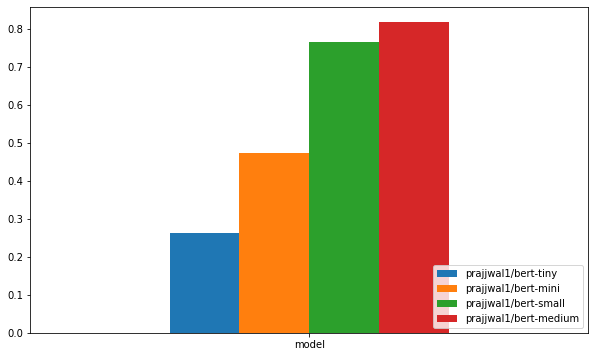

In [12]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({"model": accuracies}, index=model_ids)

print(df)
plt.rcParams['figure.figsize'] = (10,6)
ax = df.transpose().plot(kind="bar", rot=0)
ax.legend(loc=4)

In [8]:
# ! pip install torch

     |████████████████████████████████| 750.6 MB 6.7 kB/s  eta 0:00:011
